### Extract all entities from the tables. Linked them to thier Wikipedia pages, and via the Wikipedia ID to their Dbpedia/Yago labels

In [ ]:
import numpy as np
import pandas as pd
import urllib
from bs4 import BeautifulSoup
from tqdm import tqdm
from wikimapper import WikiMapper

In [2]:
from pathlib import Path
import json

In [3]:
def create_entities_dataset(data_path):
    dataset_entities = pd.DataFrame(columns=["entity"])
    with tqdm() as progress:
        with pd.read_json(data_path, lines=True, chunksize=500) as reader:
                for chunk in reader:
                    for index, t in chunk.iterrows():
                        
                        numcols = t['numCols']
                        table = t["tableData"]
                        data_rows = [ r for r in table ]                


                        for col_index in range(numcols):

                            cells = [row[col_index] for row in data_rows ] 
                            entities = [] 
                            for cell in cells:
                                entities.append([cell['surfaceLinks'][i]['target']['title'] for i in range(len(cell['surfaceLinks']))])
                            new_rows = pd.DataFrame([{"entity": e} for e in entities])
                            dataset_entities = pd.concat([dataset_entities,new_rows],ignore_index=True)
                        progress.update()

    return dataset_entities

### Read labeled instance data from dbpedia download

In [7]:
yago=pd.read_table("../data/dbpedia/instance-types_tag=specific.ttl",names=["entity","type","class","dot"],sep=" ")

In [8]:
yago.drop(["dot","type"],axis='columns',inplace=True)

In [9]:
yago.head(5)

entity  \
0                                  #   
1  <http://dbpedia.org/resource/!!!>   
2  <http://dbpedia.org/resource/!!!>   
3  <http://dbpedia.org/resource/!!!>   
4  <http://dbpedia.org/resource/!!!>   

                                               class  
0                               2016-10-07T07:09:03Z  
1  <http://dbpedia.org/class/yago/Abstraction1000...  
2  <http://dbpedia.org/class/yago/DanceBand108249...  
3     <http://dbpedia.org/class/yago/Group100031264>  
4  <http://dbpedia.org/class/yago/MusicalOrganiza...

In [ ]:
#dbpedia had 6707444 entities and classes, yago has 57878998

In [10]:
yago = yago.loc[yago["class"].str.contains(pat = "http://dbpedia.org/class/yago/")]
yago["entity"] = yago["entity"].map(lambda x : urllib.parse.unwrap(x).replace('http://dbpedia.org/resource/',''))
yago["class"] = yago["class"].map(lambda x : urllib.parse.unwrap(x).replace('http://dbpedia.org/class/yago/',''))
print(len(yago))

57878998


In [25]:
yago["class"] = yago["class"].str.replace('\d+', '', regex=True)

In [28]:
yago['class'].unique()

array(['Abstraction', 'DanceBand', 'Group', ...,
       'WikicatDefunctMotorVehicleBrandsOfJapan',
       'WikicatNovelsByLualhatiBautista', 'WikicatKlingon-languageOperas'],
      dtype=object)

In [29]:
len(yago)

57878998

In [31]:
len(yago) # after removing classes with wiki and yago down to 38610832

38610832

In [30]:
yago = yago[~yago['class'].astype(str).str.startswith('Wiki')]
yago = yago[~yago['class'].astype(str).str.startswith('Yago')]

### Extract all the entities that appear in the tables from the new dataset

In [19]:
from pathlib import Path
import pickle
from ast import literal_eval

# create dataset of entities


data_path = "../data/wiki_dbpedia_lvl_1_berttokenizerfast.json"
dataset_entities = create_entities_dataset(data_path=data_path)
print(len(dataset_entities))

#dataset_entities['entity'] = dataset_entities['entity'].apply(literal_eval) #convert to list type
dataset_entities = dataset_entities.explode("entity",ignore_index=True)

filepath = Path('../data/full_dataset_entities_expanded.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
dataset_entities.to_csv(filepath) 

"""

dataset_entities = pd.read_csv('datasets/benchmark/full_dataset_entities_expanded.csv',index_col=0)
print(len(dataset_entities)) 
"""


51293it [40:18, 21.21it/s]


2186926


"\n\ndataset_entities = pd.read_csv('datasets/benchmark/full_dataset_entities_expanded.csv',index_col=0)\nprint(len(dataset_entities)) \n"

In [20]:
dataset_entities=dataset_entities.drop_duplicates().reset_index(drop=True)
len(dataset_entities)

481864

In [21]:
dataset_entities=dataset_entities.dropna()

In [32]:
dataset_entities_classes = dataset_entities.join(yago.set_index('entity'), on="entity",how="left").reset_index(drop=True)
print(dataset_entities_classes)

                 entity                   class
0                  Biel                     NaN
1           Switzerland  AdministrativeDistrict
2           Switzerland                District
3           Switzerland                Location
4           Switzerland                  Object
...                 ...                     ...
3487337    Leila_Vaziri                 Swimmer
3487338    Leila_Vaziri                   Whole
3487339    Leila_Vaziri                  Winner
3487340    Leila_Vaziri                   Woman
3487341  Kornelia_Sirch                     NaN

[3487342 rows x 2 columns]


In [40]:
classes= dataset_entities_classes["class"].unique()

In [33]:
len(dataset_entities_classes["class"].unique())

5327

In [34]:
class_count=dataset_entities_classes.groupby( ["class"]).count()

In [35]:
class_count.sort_values(by = 'entity',ascending=False,inplace=True)

In [36]:
display(class_count)

entity
class                   
PhysicalEntity    215905
Object            212821
Whole             179039
CausalAgent       136215
LivingThing       135479
...                  ...
Imide                  1
IceAge                 1
HydrogenPeroxide       1
Husky                  1
Keelboat               1

[5326 rows x 1 columns]

### Map the entities and their classes to the Dbpedia class hierarchy

In [3]:
from pprint import pprint
import json

with open('../data/dbpedia/dbpedia_classes.json', 'r') as f:
    tree = json.load(f)
pprint(tree)

{'owl:Thing': {'Activity': {'Game': {'BoardGame': {}, 'CardGame': {}},
                            'Sales': {},
                            'Sport': {'Athletics': {}, 'TeamSport': {}}},
               'Agent': {'Deity': {},
                         'Employer': {},
                         'Family': {'NobleFamily': {}},
                         'FictionalCharacter': {'ComicsCharacter': {'AnimangaCharacter': {}},
                                                'DisneyCharacter': {},
                                                'MythologicalFigure': {},
                                                'NarutoCharacter': {},
                                                'SoapCharacter': {}},
                         'Organisation': {'Broadcaster': {'BroadcastNetwork': {},
                                                          'RadioStation': {},
                                                          'TelevisionStation': {}},
                                          'Company': {'

In [4]:
from pprint import pprint
import json

with open('../data/dbpedia/dbpedia_classes.json', 'r') as f:
    tree = json.load(f)
#pprint(tree)

def get_entities(subtree):
    result=[]
    for c,branch in subtree.items():
        result.extend([c])
        if branch !={}:
            result.extend([e for e in subtree[c]])
            branch_entities = get_entities(branch)
            result.extend([e for e in branch_entities])
    return result


classes = list(tree["owl:Thing"].keys())
my_tree= tree["owl:Thing"]

class2entity={ c: list(set(get_entities(my_tree[c]))) for c in classes}

print(class2entity)

entity2class ={} 
for c, entities in class2entity.items():
    for e in entities:
        entity2class[e]=c


e= "Beverage"

print(entity2class[e])

{'Activity': ['TeamSport', 'Game', 'BoardGame', 'Sport', 'CardGame', 'Athletics', 'Sales'], 'Agent': ['SportsLeague', 'Band', 'NobleFamily', 'AustralianFootballLeague', 'Employer', 'GovernmentAgency', 'BasketballTeam', 'ReligiousOrganisation', 'TennisLeague', 'AnimangaCharacter', 'LawFirm', 'GeopoliticalOrganisation', 'VideogamesLeague', 'IceHockeyLeague', 'SportsClub', 'CyclingTeam', 'ComedyGroup', 'SambaSchool', 'DisneyCharacter', 'Publisher', 'Non-ProfitOrganisation', 'PublicTransitSystem', 'Library', 'GovernmentCabinet', 'Bank', 'SoccerClub', 'RadioControlledRacingLeague', 'ClericalOrder', 'FieldHockeyLeague', 'TradeUnion', 'AmericanFootballTeam', 'RugbyLeague', 'HockeyClub', 'University', 'PaintballLeague', 'SoccerLeague', 'MotorcycleRacingLeague', 'SpeedwayLeague', 'TelevisionStation', 'MythologicalFigure', 'PoloLeague', 'Caterer', 'RecordOffice', 'InlineHockeyLeague', 'NarutoCharacter', 'MixedMartialArtsLeague', 'HockeyTeam', 'InternationalOrganisation', 'EducationalInstitution'

In [56]:
def expand(tree):
    result=tree
    for c,branch in result.items():
        if c !="ENTITIES":
            result[c]["ENTITIES"] = dataset_entities_classes.loc[dataset_entities_classes["class"]==c]["entity"].to_list()
            if branch != {}:
                expand(branch)
    return result

In [6]:

#entity_tree=expand(tree)
#with open('../data/dbpedia/entity_tree.json', 'w') as f:
#    json.dump(entity_tree, f)

with open('../data/dbpedia/entity_tree.json', 'r') as f:
    entity_tree = json.load(f)
#pprint(entity_tree)


In [7]:
entity_tree

{'owl:Thing': {'Activity': {'Game': {'BoardGame': {'ENTITIES': ['Wargaming',
      'Sleeping_Beauty_(1959_film)',
      'Mario_&_Sonic_at_the_Olympic_Winter_Games',
      'Pyramid_(game_show)',
      'Platoon_(film)',
      'Platoon_(film)',
      'Peter_Pan_(1953_film)',
      'Yoga_Wii',
      'Turn-based_strategy',
      'Ms._Pac-Man',
      'Wii_Fit',
      'Monopoly_(game)',
      'Cluedo',
      'The_Twilight_Zone',
      'Munchkin_(card_game)',
      'Simon_(game)',
      'Chess_at_the_2010_Asian_Games',
      'Wii_Music',
      'Xiangqi_at_the_2010_Asian_Games',
      'Blankety_Blank',
      'Small_World_(board_game)',
      'Small_World_(board_game)',
      'Tsuro',
      'Tsuro',
      'Ticket_to_Ride_(board_game)',
      'Say_Anything_(party_game)',
      'Elder_Sign_(card_game)',
      'Dixit_(card_game)',
      'Pandemic_(board_game)',
      'Last_Night_on_Earth_(game)',
      'Alhambra_(board_game)',
      'Formula_D_(board_game)',
      'Once_Upon_a_Time_(game)',
      '

In [8]:
entity_tree['owl:Thing'].keys()

dict_keys(['Activity', 'Agent', 'Algorithm', 'Altitude', 'AnatomicalStructure', 'ArchitecturalStructure', 'Area', 'Award', 'Biomolecule', 'Blazon', 'Browser', 'Cartoon', 'ChartsPlacements', 'ChemicalSubstance', 'Cipher', 'Colour', 'Covid19', 'Currency', 'Demographics', 'Depth', 'Device', 'Diploma', 'Disease', 'ElectionDiagram', 'EthnicGroup', 'Event', 'FileSystem', 'Flag', 'Food', 'GeneLocation', 'GrossDomesticProduct', 'GrossDomesticProductPerCapita', 'Holiday', 'Hospital', 'Identifier', 'Language', 'List', 'MeanOfTransportation', 'Media', 'MedicalSpecialty', 'Medicine', 'MouseGene', 'Name', 'Novel', 'Pandemic', 'PersonFunction', 'Place', 'Population', 'Protocol', 'PublicService', 'Relationship', 'Skos', 'Species', 'SportCompetitionResult', 'SportsSeason', 'Spreadsheet', 'StarCluster', 'Statistic', 'Tank', 'TimePeriod', 'TopicalConcept', 'UnitOfWork', 'Unknown', 'Work', 'cidoccrm:E4_Period', 'd0:Activity', 'foaf:Image', 'foaf:Person', 'geo:SpatialThing', 'gml:_Feature', 'prov:Entity',

In [64]:
labels_dict = {"Activity": [], "Organisation": [], "ArchitecturalStructure":[], "Event":[], "Place":[], "Person":[], "Work":[]}

In [62]:
def populate_main_classes(flattened_dict, nested_dict, parent_key=""):
    for key, value in nested_dict.items():
        if key in flattened_dict:
            if "ENTITIES" in value:
                flattened_dict[key].extend(value["ENTITIES"])
            if isinstance(value, dict):
                flattened_dict[key].extend(assemble_entities(value))

In [63]:
def assemble_entities(subtree):
    result=[]
    for c,branch in subtree.items():
        if c != "ENTITIES":
            result.extend([e for e in subtree[c]["ENTITIES"]])
            branch_entities = assemble_entities(branch)
            result.extend([e for e in branch_entities])
    return result

In [ ]:
print(set(assemble_entities(entity_tree))==set(dataset["entity"].to_list()))
print(len(assemble_entities(entity_tree))==647153) 

In [119]:
test = populate_main_classes(labels_dict,entity_tree["owl:Thing"]["Species"]["Eukaryote"]["Animal"])

In [115]:
labels_dict.keys()

dict_keys(['Activity', 'Organisation', 'ArchitecturalStructure', 'Event', 'Place', 'Person', 'Work'])

In [122]:
for key, val in labels_dict.items():
    print(key, len(set(val)))

Activity 7393
Organisation 31946
ArchitecturalStructure 16052
Event 34616
Place 40227
Person 133215
Work 14341


In [126]:
entity_class_pairs = [(entity,class_name) for class_name, entities in labels_dict.items() for entity in entities]
labeled_entities =  pd.DataFrame(entity_class_pairs,columns=['entity','class'])

In [127]:
labeled_entities

entity     class
0       Cross-country_skiing_at_the_Winter_Olympics  Activity
1                                Bachelorette_party  Activity
2                                        Chemotroph  Activity
3                                      FIU_Panthers  Activity
4                                       UNLV_Rebels  Activity
...                                             ...       ...
614723                      European_Fiscal_Compact      Work
614724                         Armistice_of_Mudanya      Work
614725                       Treaty_of_Alexandropol      Work
614726                          Inter-Korean_Summit      Work
614727                                  Magna_Carta      Work

[614728 rows x 2 columns]

### Map the labeled entities to their wikidata ids using the WikiMapper

In [149]:
from wikimapper import WikiMapper

mapper = WikiMapper("../data/index_enwiki-latest.db")

labeled_entities["wikidata_id"] = labeled_entities.apply(lambda x : mapper.title_to_id(x["entity"]),axis=1)
print(labeled_entities)
print(labeled_entities["wikidata_id"].isnull().sum())

                                             entity     class wikidata_id
0       Cross-country_skiing_at_the_Winter_Olympics  Activity     Q676750
1                                Bachelorette_party  Activity      Q56707
2                                        Chemotroph  Activity     Q747472
3                                      FIU_Panthers  Activity    Q3110096
4                                       UNLV_Rebels  Activity    Q3421770
...                                             ...       ...         ...
614543                               1978_in_poetry      Work    Q4578439
614544                               1977_in_poetry      Work    Q4577920
614545                               1976_in_poetry      Work    Q4577415
614547                                  Os_Lusíadas      Work     Q781898
614548                              Nagarakretagama      Work      Q49335

[250491 rows x 3 columns]
1013


/var/folders/zs/qtbkgfnj1bd_qhkkmfc294j80000gn/T/ipykernel_26079/3087571085.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_entities["wikidata_id"] = labeled_entities.apply(lambda x : mapper.title_to_id(x["entity"]),axis=1)


In [163]:
filepath = Path('../data/full_dataset_entities_labels_yago_specific.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
labeled_entities.to_csv(filepath) 

In [156]:
len(labeled_entities["class"].unique())

7

In [153]:
labeled_entities.loc[labeled_entities["entity"].str.contains("Robbie_Williams")]

entity   class wikidata_id
254606                        Robbie_Williams  Person      Q47875
262926                      Robbie_Williamson  Person    Q7341028
602135  Greatest_Hits_(Robbie_Williams_album)    Work    Q1028072
608500          Angels_(Robbie_Williams_song)    Work     Q769491

In [160]:
labeled_entities.dropna(subset=['wikidata_id'], inplace=True)

In [161]:
class_count=labeled_entities.groupby( ["class"]).count()

In [162]:
display(class_count)

entity  wikidata_id
class                                      
Activity                  7344         7344
ArchitecturalStructure   14945        14945
Event                    26535        26535
Organisation             31400        31400
Person                  130514       130514
Place                    29998        29998
Work                      8742         8742

In [ ]:
#dataset.to_csv("full_dataset_entities_expanded_yago_classes_dbpedia_tree.csv")

### Here adding labels from dbpedia instances

In [9]:
dbpedia=pd.read_table("../data/dbpedia/instance-types_lang=en_specific.ttl",names=["entity","type","class","dot"],sep=" ")

In [10]:
dbpedia.drop(["dot","type"],axis='columns',inplace=True)

In [11]:
dbpedia = dbpedia.loc[dbpedia["class"].str.contains(pat = "http://dbpedia.org/ontology/")]
dbpedia["entity"] = dbpedia["entity"].map(lambda x : urllib.parse.unwrap(x).replace('http://dbpedia.org/resource/',''))
dbpedia["class"] = dbpedia["class"].map(lambda x : urllib.parse.unwrap(x).replace('http://dbpedia.org/ontology/',''))
print(len(dbpedia))

6992319


In [45]:
dataset = pd.read_csv("../data/full_dataset_entities_expanded.csv")
dataset.drop('Unnamed: 0', axis=1, inplace=True)

In [48]:
dataset.head(5)

entity
0         Biel
1  Switzerland
2       Berlin
3      Germany
4    São_Paulo

In [49]:
dataset_entities_classes = dataset_entities.join(dbpedia.set_index('entity'), on="entity",how="left").reset_index(drop=True)
print(dataset_entities_classes)

                   entity    class
0                    Biel      NaN
1             Switzerland  Country
2                  Berlin     City
3                 Germany  Country
4               São_Paulo     Town
...                   ...      ...
481858     Jackie_Willmot      NaN
481859  Deborah_Babashoff  Swimmer
481860     Hayley_Peirsol  Swimmer
481861       Leila_Vaziri  Swimmer
481862     Kornelia_Sirch      NaN

[481863 rows x 2 columns]


In [51]:
dataset_entities_classes[dataset_entities_classes["entity"]=="Robbie_Williams"]

entity class
472  Robbie_Williams   NaN

In [52]:
dataset_entities_classes=dataset_entities_classes.loc[dataset_entities_classes["class"].notna()]
print(len(dataset_entities_classes))
print(dataset_entities_classes)

225092
                   entity    class
1             Switzerland  Country
2                  Berlin     City
3                 Germany  Country
4               São_Paulo     Town
5                  Brazil  Country
...                   ...      ...
481851   Stephanie_Ortwig  Athlete
481856   Jennifer_Turrall  Swimmer
481859  Deborah_Babashoff  Swimmer
481860     Hayley_Peirsol  Swimmer
481861       Leila_Vaziri  Swimmer

[225092 rows x 2 columns]


In [60]:
with open('../data/dbpedia/dbpedia_classes.json', 'r') as f:
    tree = json.load(f)

In [61]:
entity_tree=expand(tree)
with open('../data/dbpedia/entity_tree_dbs.json', 'w') as f:
    json.dump(entity_tree, f)

In [69]:
print(set(assemble_entities(entity_tree))==set(dataset_entities_classes["entity"].to_list()))
print(len(assemble_entities(entity_tree))==225092) 

True
True


In [68]:
len(assemble_entities(entity_tree))

225092

In [86]:
entity_tree["owl:Thing"].keys()

dict_keys(['Activity', 'Agent', 'Algorithm', 'Altitude', 'AnatomicalStructure', 'ArchitecturalStructure', 'Area', 'Award', 'Biomolecule', 'Blazon', 'Browser', 'Cartoon', 'ChartsPlacements', 'ChemicalSubstance', 'Cipher', 'Colour', 'Covid19', 'Currency', 'Demographics', 'Depth', 'Device', 'Diploma', 'Disease', 'ElectionDiagram', 'EthnicGroup', 'Event', 'FileSystem', 'Flag', 'Food', 'GeneLocation', 'GrossDomesticProduct', 'GrossDomesticProductPerCapita', 'Holiday', 'Hospital', 'Identifier', 'Language', 'List', 'MeanOfTransportation', 'Media', 'MedicalSpecialty', 'Medicine', 'MouseGene', 'Name', 'Novel', 'Pandemic', 'PersonFunction', 'Place', 'Population', 'Protocol', 'PublicService', 'Relationship', 'Skos', 'Species', 'SportCompetitionResult', 'SportsSeason', 'Spreadsheet', 'StarCluster', 'Statistic', 'Tank', 'TimePeriod', 'TopicalConcept', 'UnitOfWork', 'Unknown', 'Work', 'cidoccrm:E4_Period', 'd0:Activity', 'foaf:Image', 'foaf:Person', 'geo:SpatialThing', 'gml:_Feature', 'prov:Entity',

In [111]:
labels_dict = {"Activity": [], "Organisation": [], "ArchitecturalStructure":[], "Event":[], "Place":[], "Person":[], "Work":[]}

In [112]:
# populate Person
populate_main_classes(labels_dict,entity_tree["owl:Thing"]["Species"]["Eukaryote"]["Animal"])
# populate Organization
populate_main_classes(labels_dict,entity_tree["owl:Thing"]["Agent"])
# the rest: Event, Place, ArchStruct, Work
populate_main_classes(labels_dict,entity_tree["owl:Thing"])

In [113]:
len(labels_dict['Person'])

121657

In [114]:
for key, val in labels_dict.items():
    print(key, len(set(val)))

Activity 109
Organisation 18719
ArchitecturalStructure 11149
Event 10486
Place 27696
Person 121657
Work 24810


In [115]:
entity_class_pairs = [(entity,class_name) for class_name, entities in labels_dict.items() for entity in entities]
labeled_entities =  pd.DataFrame(entity_class_pairs,columns=['entity','class'])

In [116]:
class_count=labeled_entities.groupby(["class"]).count()["entity"]

In [119]:
class_count

class  entity
0                Activity     109
1  ArchitecturalStructure   11149
2                   Event   10486
3            Organisation   18719
4                  Person  121657
5                   Place   27696
6                    Work   24810

In [120]:
from wikimapper import WikiMapper

mapper = WikiMapper("../data/index_enwiki-latest.db")

labeled_entities["wikidata_id"] = labeled_entities.apply(lambda x : mapper.title_to_id(x["entity"]),axis=1)
print(labeled_entities)
print(labeled_entities["wikidata_id"].isnull().sum())

                    entity     class wikidata_id
0                 Scrabble  Activity     Q170436
1              Spelljammer  Activity    Q1060172
2          Monopoly_(game)  Activity      Q17243
3                   Cluedo  Activity      Q17245
4       Classic_BattleTech  Activity    Q5128099
...                    ...       ...         ...
214621      Candida_(play)      Work    Q3509127
214622           Peer_Gynt      Work     Q208094
214623     Peter_and_Wendy      Work    Q3435337
214624            Vellekla      Work    Q3373410
214625    Arinbjarnarkviða      Work    Q3622616

[214626 rows x 3 columns]
21


In [121]:
filepath = Path('../data/full_dataset_entities_labels_dbp.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
labeled_entities.to_csv(filepath) 

## Merging the labeled entities into one file

In [3]:
dataset_entities_dbp  = pd.read_csv('../data/full_dataset_entities_labels_dbp.csv',index_col=0)
dataset_entities_dbp.dropna(inplace=True)

In [4]:
dataset_entities_yago = pd.read_csv('../data/full_dataset_entities_labels_yago_specific.csv',index_col=0)
dataset_entities_yago.dropna(inplace=True)

In [5]:
len(dataset_entities_dbp), len(dataset_entities_yago)

(214605, 249478)

In [6]:
dataset_entities_dbp['source'] = 'dbp'
dataset_entities_yago['source'] = 'yago'

In [12]:
merged_df = pd.concat([dataset_entities_dbp, dataset_entities_yago], axis = 0, ignore_index=True)

In [13]:
len(merged_df)

464083

In [15]:
merged_df.head(5)

entity     class wikidata_id source
0            Scrabble  Activity     Q170436    dbp
1         Spelljammer  Activity    Q1060172    dbp
2     Monopoly_(game)  Activity      Q17243    dbp
3              Cluedo  Activity      Q17245    dbp
4  Classic_BattleTech  Activity    Q5128099    dbp

In [16]:
# Identify duplicate entities
duplicate_entities = merged_df[merged_df.duplicated(subset=['entity','class','wikidata_id'], keep=False)]

In [17]:
len(duplicate_entities)

325684

In [18]:
merged_df = merged_df.drop_duplicates(subset=['entity','class','wikidata_id'], keep='first')

In [20]:
merged_df = merged_df.drop_duplicates(subset=['entity','wikidata_id'], keep='first')

In [21]:
len(merged_df)

282321

In [187]:
duplicate_entity = merged_df[merged_df.duplicated(subset=['entity', 'wikidata_id'], keep=False)]

In [22]:
class_count = merged_df.groupby('class')['entity'].count().reset_index()

In [23]:
class_count

class  entity
0                Activity    4184
1  ArchitecturalStructure   15118
2                   Event   20569
3            Organisation   31794
4                  Person  150744
5                   Place   32856
6                    Work   27056

In [200]:
class_count # previous when keeping the yago labels

class  entity
0                Activity    7387
1  ArchitecturalStructure   15668
2                   Event   29098
3            Organisation   32720
4                  Person  150978
5                   Place   30957
6                    Work   15513

In [24]:
merged_df.to_csv("../data/full_dataset_entities_labeled_dbp_yago_final.csv") # use this one for labeling the dataset

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

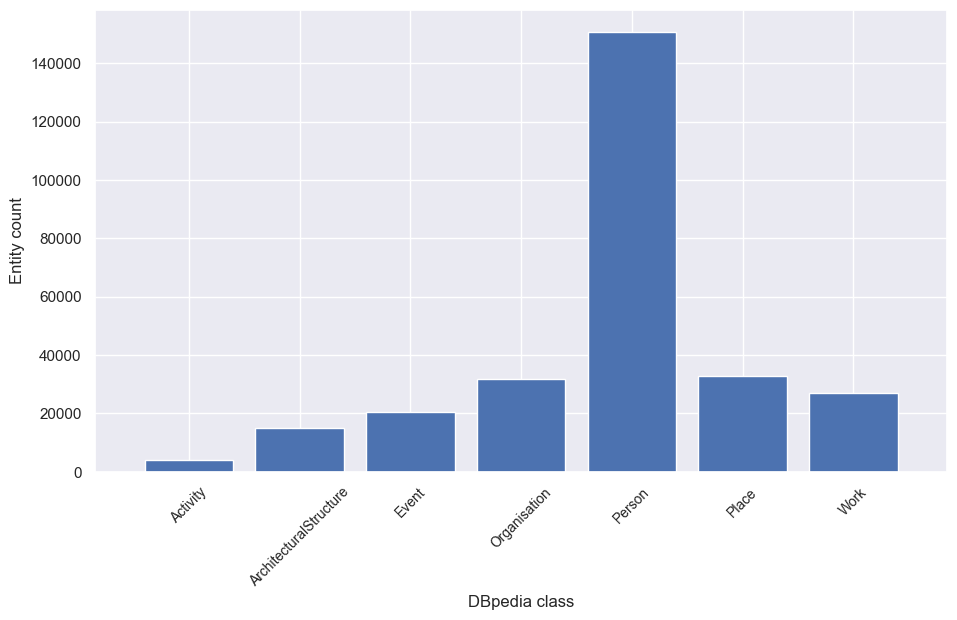

In [26]:
sns.set(rc={'figure.figsize':(11,6)})
fig, ax = plt.subplots(1)

sns.histplot(class_count,x="class",y="entity",ax=ax, stat="count", discrete=True)
ax.bar(class_count["class"],class_count["entity"])

ax.set(ylabel="Entity count")
ax.set(xlabel="DBpedia class")

plt.xticks(fontsize=10, rotation=45)
plt.savefig("plots/final_labeled_entities.png")
#plt.tight_layout()
plt.show()

In [ ]:
|